In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import requests
import tarfile
from io import BytesIO
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# --------------------------------------------------
def wrangle_ground_truth_data(gt):

    # Convert to numeric, and set errors='coerce' to convert non-numeric values to NaN
    gt['Plant 1'] = pd.to_numeric(gt['Plant 1'], errors='coerce')

    # Drop rows with NaN values in the 'Plant 1' column
    gt = gt.dropna(subset=['Plant 1'])

    # Now you can convert to int
    gt['Plant 1'] = gt['Plant 1'].astype(int)
    
    # Convert all columns to numeric
    plant_cols = ['Plant 1', 'Plant 2', 'Plant 3', 'Plant 4', 'Plant 5', 'Plant 6', 'Plant 7', 'Plant 8', 'Plant 9', 'Plant 10', 'Plant 11']

    for col in plant_cols:
        gt[col] = pd.to_numeric(gt[col], errors='coerce')
        gt[col] = gt[col].astype(int, errors='ignore')

    # Drop rows with non-numeric values in the plant columns
    gt = gt[gt[plant_cols].applymap(np.isreal).all(1)].reset_index()

    gt = gt.set_index('plot').melt(ignore_index=False).rename(columns={'variable': 'plant_name', 'value': 'ground_truth_counts'}).reset_index().dropna()

    gt['ground_truth_counts'] = gt['ground_truth_counts'].astype(int)

    return gt


# --------------------------------------------------
def download_panicle_detection_tar(url):

    # Download the tar file
    response = requests.get(url)
    tar_file = tarfile.open(fileobj=BytesIO(response.content))

    # Extract the CSV file name
    csv_file = [i for i in tar_file.getnames() if i.endswith('.csv')][0]

    # Extract the CSV file and convert it to a pandas DataFrame
    extracted_file = tar_file.extractfile(csv_file)
    df = pd.read_csv(extracted_file)

    return df


# --------------------------------------------------
def filter_detections(df, threshold=0.95):

    # Filter out low-confidence detections
    df = df[df['pred_conf']>=threshold]

    return df


# --------------------------------------------------
def rename_plants(df):

    # Assuming df is your DataFrame
    # First, sort the DataFrame by 'lat'
    df = df.sort_values('lat')

    # Create a dictionary to store the new names for each plot
    new_names = {}

    # Iterate over the DataFrame
    for index, row in df.iterrows():
        # If the plot is not in the dictionary, add it
        if row['plot'] not in new_names:
            new_names[row['plot']] = {}

        # If the plant_name is not in the dictionary for this plot, add it
        if row['plant_name'] not in new_names[row['plot']]:
            # The new name is "Plant " followed by the current size of the dictionary + 1
            new_names[row['plot']][row['plant_name']] = 'Plant ' + str(len(new_names[row['plot']]) + 1)

        # Replace the plant_name in the DataFrame with the new name
        df.at[index, 'plant_name'] = new_names[row['plot']][row['plant_name']]

    # Assuming df is your DataFrame
    md = df.groupby(['plot', 'plant_name']).size().reset_index(name='model_prediction_counts')

    return md, df


# --------------------------------------------------
def get_ground_truth_plant_count(gt):
    
    output_dict = {}

    cnt = 0
    for plot in gt['plot'].unique():

        cnt += 1
        temp_df = gt[gt['plot']==plot]
        num_plants = len(temp_df['plant_name'].unique())

        output_dict[cnt] = {
            'plot': plot,
            'number_plants': num_plants
        }
    
    number_plants_df = pd.DataFrame.from_dict(output_dict, orient='index')

    return number_plants_df


# --------------------------------------------------

# Prepare ground truth

In [3]:
# Read the ground truth data from CSV files on CyVerse & drop unnecessary columns
gt_wl = pd.read_csv('https://data.cyverse.org/dav-anon/iplant/projects/phytooracle/sorghum_panicle_detection_models/ground_truth/Tiller_Counts_2021_North_Sorghum_WL.csv').rename(columns={'Plot': 'plot'}).set_index('plot')
gt_ww = pd.read_csv('https://data.cyverse.org/dav-anon/iplant/projects/phytooracle/sorghum_panicle_detection_models/ground_truth/Tiller_Counts_2021_North_Sorghum_WW.csv').rename(columns={'Plot': 'plot'}).set_index('plot')
gt_ww = gt_ww.drop(['Unnamed: 0', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'], axis=1)

# Combine the two dataframes, from each irrigation treatment, into a single dataframe
gt = pd.concat([gt_wl, gt_ww])

# Prepare data
gt = wrangle_ground_truth_data(gt=gt)

/tmp/ipykernel_36355/680905834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt['Plant 1'] = gt['Plant 1'].astype(int)
/tmp/ipykernel_36355/680905834.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt[col] = pd.to_numeric(gt[col], errors='coerce')
/tmp/ipykernel_36355/680905834.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [4]:
number_plants_df = get_ground_truth_plant_count(gt=gt)

# Prepare model predictions

In [5]:
# Download tar file containing panicle detection CSV from CyVerse
df = download_panicle_detection_tar(url="https://data.cyverse.org/dav-anon/iplant/projects/phytooracle/season_12_sorghum_soybean_sunflower_tepary_yr_2021/level_2/stereoTop/sorghum/2021-10-18__10-00-56-076_sorghum/2021-10-18__10-00-56-076_sorghum_detect_out.tar")



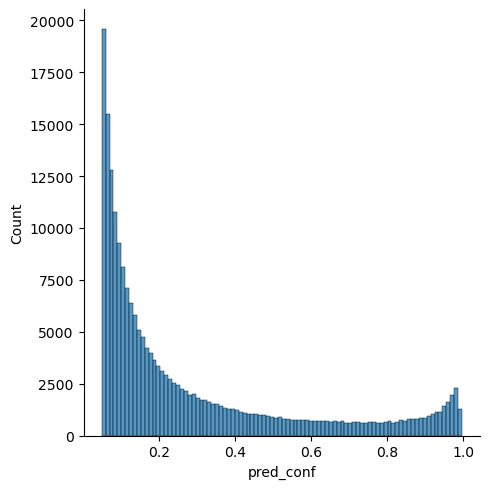

In [6]:
sns.displot(x='pred_conf', data=df)

In [7]:
# Filter out low-confidence panicle detections
df = filter_detections(df=df,  threshold=0.9)

# Rename plants to enable merge with ground truth panicle counts
md, df = rename_plants(df=df)

In [8]:
# for plot in md['plot'].unique()[40:41]:
#     temp_df = md[md['plot']==plot]
#     len_plants = len(temp_df)

#     gt_temp = number_plants_df[number_plants_df['plot']==plot]['number_plants']
#     gt_len_plants = gt_temp.values[0]
    
#     if len_plants == gt_len_plants:
#         print('Lengths match.')
#     else:
#         df_df = df[df['plot']==plot]
#         print(df_df)

In [9]:
md_update = []

for plot in md['plot'].unique():
    temp_df = md[md['plot']==plot]
    len_plants = len(temp_df)

    gt_temp = number_plants_df[number_plants_df['plot']==plot]['number_plants']
    if not gt_temp.empty:
        gt_len_plants = gt_temp.values[0]
        
        if len_plants == gt_len_plants:
            print('Lengths match.')
            df_df = df[df['plot']==plot]
            df_df = pd.DataFrame(df_df['plant_name'].value_counts()).reset_index().sort_values('count', ascending=False)
            md_update.append(df_df)

        else:
            print('Lengths do not match.')
            df_df = df[df['plot']==plot]
            df_df = pd.DataFrame(df_df['plant_name'].value_counts()).reset_index().sort_values('count', ascending=False)[:gt_len_plants].rename(columns={'count': 'model_prediction_counts'})
            df_df['plot'] = plot
            md_update.append(df_df)
            # # Sort df_df by 'lat' and 'Lon' columns in ascending order
            # df_df = df_df.sort_values(by=['lat', 'Lon'])
            
            # # Renumber the plants starting from 1
            # df_df['plant_number'] = np.arange(1, len(df_df) + 1)
            
            # print(df_df)

Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths match.
Lengths do not match.
Lengths match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths match.
Lengths match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths do not match.
Lengths match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths do not match.
Lengths match.
Lengths do not match.

In [10]:
md = pd.concat(md_update)[['plot', 'plant_name', 'model_prediction_counts']]

In [11]:
md

,plot,plant_name,model_prediction_counts
0,5602.0,Plant 1,2.0
0,5603.0,Plant 1,3.0
1,5603.0,Plant 2,3.0
2,5603.0,Plant 3,1.0
0,5605.0,Plant 2,5.0
...,...,...,...
2,NaN,Plant 2,NaN
3,NaN,Plant 3,NaN
4,NaN,Plant 5,NaN
0,9231.0,Plant 1,1.0


# Merge ground truth and model predictions

In [12]:
# Merge the two dataframes
df = gt.merge(md, on=['plot', 'plant_name'])

# Drop rows with NA values
df = df.dropna(subset=['ground_truth_counts', 'model_prediction_counts'])

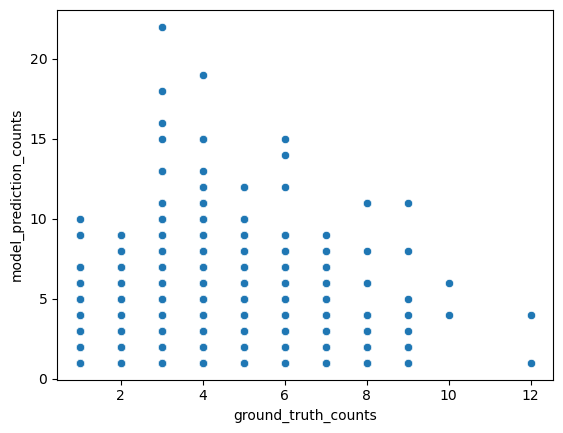

In [13]:
sns.scatterplot(x='ground_truth_counts', y='model_prediction_counts', data=df)
plt.savefig('ground_truth_model_prediction_corr.png', dpi=900)

In [14]:
df.to_csv('season12_panicle_detection_validation.csv', index=False)